# 14. Transformer 번역기 만들기

## 1. Transformer모델 생성
### 1) positional_encoding


In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("슝=3")

슝=3


In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn # Attention 시각화를 위해 필요!

print(tf.__version__)

2.6.0


### 1) positional_encoding 생성

In [4]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

print("슝=3")

슝=3


### 2) MultiHeadAttention 생성

In [5]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
     
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

### 3) poswiseFeedforward network 생성

In [6]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

print("슝=3")

슝=3


### 4) encoder layer 생성

In [7]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

print("슝=3")

슝=3


### 5) decoder layer 생성

In [8]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

### 6) Transformer encoder 생성

In [9]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

print("슝=3")

슝=3


### 7) Transformer decoder 생성

In [10]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

print("슝=3")

슝=3


### 8) Transformer 생성

In [11]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [12]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

print("슝=3")

슝=3


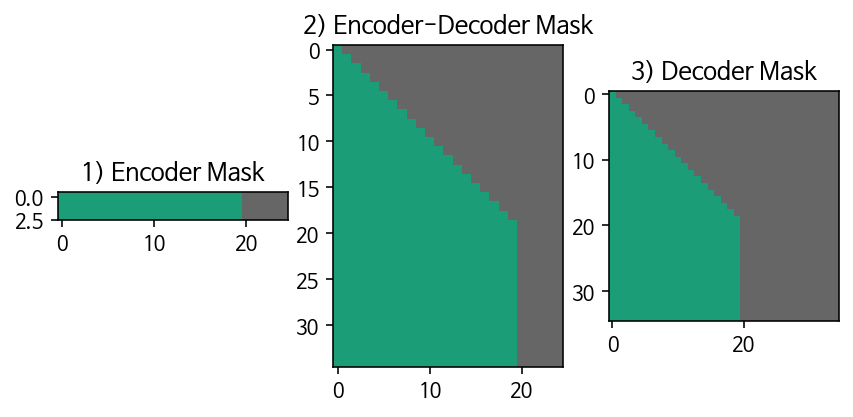

In [13]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

### 10) 학습률 설정

In [14]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

print("슝=3")

슝=3


# 2. 데이터 수집 및 가공
### 1) 데이터 수집

In [15]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"

# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    raw = zip(kor, eng)
    cleaned_corpus = set(raw)

    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

In [16]:
kor_corpus, eng_corpus = zip(*cleaned_corpus)
print(len(kor_corpus), len(eng_corpus))

78968 78968


### 2) 데이터 가공

In [17]:
def preprocess_sentence(sentence):
    
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!가-힣ㄱ-ㅎ]+", " ", sentence)

    sentence = sentence.strip()
    
    return sentence

In [18]:
enc_corpus = []
dec_corpus = []

for kor, eng in zip(kor_corpus, eng_corpus):
    temp_kor = preprocess_sentence(kor)
    temp_eng = preprocess_sentence(eng)

    enc_corpus.append(temp_kor)
    dec_corpus.append(temp_eng)
    
print('korean data size:', len(enc_corpus))
print('english data size:', len(dec_corpus))
print("Korean:", enc_corpus[500])   
print("English:", dec_corpus[500])  

korean data size: 78968
english data size: 78968
Korean: 부시는 한반도에 포악한 정권이 두려움과 기아에 살고 있는 국민을 지배하고 있다 고 말했다 .
English: on the korean peninsula an oppressive regime rules a people living in fear and starvation bush said .


# 3. 데이터 정제 및 토큰화
### 1) sentencepiece 를 통한 토큰화

In [21]:
import sentencepiece as spm
import os

# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus, vocab_size, lang="ko", pad_id=0, bos_id=1, eos_id=2, unk_id=3):
    model_name = f"{lang}_spm"
    print('c')

    # 텍스트 파일로 코퍼스 저장
    temp_file = f"{model_name}.temp"
    with open(temp_file, 'w', encoding='utf-8') as f:
        for line in corpus:
            f.write(f'{line}\n')
    print('l')

    # SentencePiece 모델 학습
    spm.SentencePieceTrainer.Train(
        f'--input={temp_file} --model_prefix={model_name} '
        f'--vocab_size={vocab_size} --character_coverage=1.0 '
        f'--pad_id={pad_id} --bos_id={bos_id} --eos_id={eos_id} --unk_id={unk_id}'
    )
    print('e')

    # 생성된 모델 로드
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f"{model_name}.model")
    print('a')

    # 임시 파일 삭제
    os.remove(temp_file)
    print('r')

    return tokenizer

In [10]:
#뭐가 잘못되었다
# import sentencepiece as spm

# def generate_tokenizer(corpus,
#                         vocab_size,
#                         lang="ko",
#                         pad_id=0,
#                         bos_id=1,
#                         eos_id=2,
#                         unk_id=3):
#     model_name = f"{lang}_spm"

#     spm.SentencePieceTrainer.Train(
#         '--input={} --model_prefix={} --vocab_size={} --pad_id={} --bos_id={} --eos_id={} --unk_id={}'.format(corpus,model_name, vocab_size, pad_id, bos_id, eos_id, unk_id))
#     print('clear')

#     # Sentencepiece 사전을 생성합니다.
#     tokenizer = spm.SentencePieceProcessor()
#     tokenizer.Load('{}.model'.format(model_name))
#     pritn('clear2')

#     # 임시 파일 삭제
#     os.remove(temp_file)

#     return tokenizer

In [24]:
cleaned_corpus
print(kor_corpus[0])
print(eng_corpus[0])
print(enc_corpus[0])
print(dec_corpus[0])

터넨트는 어미 곰의 둔부에 진정제를 놓았지만 근육이 아닌 살에 꽂힌 탓에 약 성분의 흡수가 늦어지고 있었다.
The wildlife biologist shoots a tranquilizer dart into the mother's rump, but the dart goes into fat, not muscle, slowing absorption into her blood.
터넨트는 어미 곰의 둔부에 진정제를 놓았지만 근육이 아닌 살에 꽂힌 탓에 약 성분의 흡수가 늦어지고 있었다 .
the wildlife biologist shoots a tranquilizer dart into the mother s rump but the dart goes into fat not muscle slowing absorption into her blood .


In [23]:
# enc_corpus = []
# dec_corpus = []

SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

ko_tokenizer = generate_tokenizer(enc_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(dec_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

c
l


sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=ko_spm.temp --model_prefix=ko_spm --vocab_size=20000 --character_coverage=1.0 --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ko_spm.temp
  input_format: 
  model_prefix: ko_spm
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece:

e
a
r
c
l
e
a
r


sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: en_spm.temp
  input_format: 
  model_prefix: en_spm
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
}
normalizer_spec {
  name: nmt_nfkc
  add_dummy_prefix: 1
  remove_extra_whitespaces: 1
  escape_whitespac

True

In [25]:
#원활한 진행을 위하여 변수 카피 진행
import copy

kor_corpus = copy.deepcopy(enc_corpus)
eng_corpus = copy.deepcopy(dec_corpus)

In [26]:
import tensorflow as tf
from tqdm.notebook import tqdm    # 진행 과정을 보기 위한 도구

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다.
for idx in tqdm(range(len(kor_corpus))):
    src_tok = ko_tokenizer.EncodeAsIds(kor_corpus[idx])  # 한국어 문장 토큰화
    tgt_tok = en_tokenizer.EncodeAsIds(eng_corpus[idx])  # 영어 문장 토큰화

    if len(src_tok) <= 50 and len(tgt_tok) <= 50:  # 토큰 길이가 50 이하인 경우만 선택
        src_corpus.append(src_tok)
        tgt_corpus.append(tgt_tok)

# 패딩처리를 완료하여 학습용 데이터를 완성합니다.
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/78968 [00:00<?, ?it/s]

In [41]:
# 원하는 인덱스의 데이터에 대해서만 수행
# 정현님 코드 참조

for i in range(10):
    src_sequence = enc_train[i - 1]    
    src_tokens = [ko_tokenizer.IdToPiece(int(token)) for token in src_sequence if token != 0]
#     print(src_sequence)
    print(src_tokens)

['▁부시', '▁대통령이', '▁탈북자들', '을', '▁만난', '▁것은', '▁년', '▁월', '▁강철', '환', '씨', '를', '▁집무실', '로', '▁초대', '한', '▁이후', '▁이번', '이', '▁두', '▁번째', '이다', '▁.']
['▁터넨트', '는', '▁어미', '▁곰', '의', '▁둔', '부', '에', '▁진정제', '를', '▁놓았', '지만', '▁근육', '이', '▁아닌', '▁살', '에', '▁', '꽂', '힌', '▁', '탓', '에', '▁약', '▁성분', '의', '▁흡수', '가', '▁', '늦', '어', '지', '고', '▁있었다', '▁.']
['▁약물', '▁치료', '를', '▁하는', '▁고혈압', '▁환자들', '은', '▁손', '으로', '▁하는', '▁마사지', '를', '▁피해', '야', '▁한다', '▁.']
['▁한편', '▁이라크', '▁북부', '▁지역', '의', '▁최고', '▁미', '▁사령관', '은', '▁이', '▁지역에', '▁연합군', '이', '▁년', '▁반', '▁동안', '▁더', '▁주둔', '해야', '▁한다고', '▁지적했다', '▁.']
['▁케네디', '는', '▁타임즈', '에서', '▁자신이', '▁상원의원직', '에', '▁가장', '▁적합한', '지에', '▁대한', '▁질문에', '▁가장', '▁적합', '하다고', '▁생각하지', '▁않았다면', '▁여기', '▁있지', '▁않을', '▁것', '▁이라고', '▁말했다', '▁.']
['▁그러나', '▁많은', '▁여성', '▁단체들', '과', '▁예술가들', '은', '▁법에', '▁의해', '▁외', '설', '로', '▁치', '부', '되는', '▁것', '들이', '▁법적', '인', '▁제재', '를', '▁받게', '되는', '▁경우', '▁표현', '의', '▁자유', '까지', '도', '▁침해', '할', '▁수', '▁있다고', '▁우려', '하고'

# 4. 훈련하기 
### 1) 트렌스포머 선언

In [28]:
# LearningRateScheduler

# 트랜스포머 선언

# Hyperparameters
N_LAYERS = 2
D_MODEL = 512
N_HEADS = 8
D_FF = 2048
POS_LEN = 200  # 이 값은 데이터셋에 따라 조정될 수 있습니다.
DROPOUT = 0.1

# Transformer 인스턴스 생성
transformer = Transformer(
    n_layers=N_LAYERS,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    d_ff=D_FF,
    src_vocab_size=SRC_VOCAB_SIZE,
    tgt_vocab_size=TGT_VOCAB_SIZE,
    pos_len=POS_LEN,
    dropout=DROPOUT
)

### 2) 손실함수 정의

In [29]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

### 3) Train step 함수 선정

In [30]:
# train_step 함수 완성
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

### 4) attention 시각화 함수 생성

In [31]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

### 5) 번역 생성 함수 선정

In [32]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [33]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [34]:
# 학습

from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 20

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

/tmp/ipykernel_177/1811356450.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s obama is a victory .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city of the city s .
Input: 커피는 필요 없다.
Predicted translation: the united states is a good .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the city of the city of the city .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president elect barack obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is a city of the city .
Input: 커피는 필요 없다.
Predicted translation: coffee coffee there is no .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the president s president obama s aides .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s urban city is the streets .
Input: 커피는 필요 없다.
Predicted translation: no coffees .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven died tuesday when the crashed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is doing .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is the city of urban city .
Input: 커피는 필요 없다.
Predicted translation: don t need to do anything .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from the people were killed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the citizens are a target .
Input: 커피는 필요 없다.
Predicted translation: coffee need doesn t need for coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died monday when the plane crashed into the city sunday .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a point .
Input: 시민들은 도시 속에 산다.
Predicted translation: people in urban city .
Input: 커피는 필요 없다.
Predicted translation: no need for no need for no .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed monday night without the deaths .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president for nearly years .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are similar to the mayor .
Input: 커피는 필요 없다.
Predicted translation: no he needs to defend coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re in the city s urban city .
Input: 커피는 필요 없다.
Predicted translation: he needs to take a special or .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people seven died when seven came seven days .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the illinois senator .
Input: 시민들은 도시 속에 산다.
Predicted translation: street .
Input: 커피는 필요 없다.
Predicted translation: need for coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a strong president .
Input: 시민들은 도시 속에 산다.
Predicted translation: people are through the city of long .
Input: 커피는 필요 없다.
Predicted translation: no need to hold necessary .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people seven died seventh on saturday night .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the only republican .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are similar to the city s good .
Input: 커피는 필요 없다.
Predicted translation: no needs to coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven seven seven seven seven seven seven seven seven seven seven years ago seven will die .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: people will be homeless .
Input: 커피는 필요 없다.
Predicted translation: no he needs to do he .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: six people were killed seven people .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s presidential campaign .
Input: 시민들은 도시 속에 산다.
Predicted translation: people will mayor s city only .
Input: 커피는 필요 없다.
Predicted translation: no he needs to take coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed seven people .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the same term .
Input: 시민들은 도시 속에 산다.
Predicted translation: and they re mayor of s ahead .
Input: 커피는 필요 없다.
Predicted translation: no needs to be coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed seven people .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is only a list of basis .
Input: 시민들은 도시 속에 산다.
Predicted translation: people will mayor us a baby .
Input: 커피는 필요 없다.
Predicted translation: no he needs to take coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven died seven people when seventh were killed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the second president .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens are vowing to take place in the city .
Input: 커피는 필요 없다.
Predicted translation: no needs to take coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven died seven days earlier . regarded the injuries .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the president obama is said to be nearly a surveillance .
Input: 시민들은 도시 속에 산다.
Predicted translation: to city urban rural street .
Input: 커피는 필요 없다.
Predicted translation: no needs to take coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed and seven were killed thursday .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama campaigns .
Input: 시민들은 도시 속에 산다.
Predicted translation: mayor .
Input: 커피는 필요 없다.
Predicted translation: he needs to take coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed thursday when seven people were killed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the only son .
Input: 시민들은 도시 속에 산다.
Predicted translation: people will see their city s stop .
Input: 커피는 필요 없다.
Predicted translation: no need to take coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed .


  0%|          | 0/1150 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president s passion .
Input: 시민들은 도시 속에 산다.
Predicted translation: people will mayor to take their city .
Input: 커피는 필요 없다.
Predicted translation: coffee needs .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed .


# 회고 

- 모델 구축하여 번역문까지 결과를 확인하였습니다.
- 토큰화하는 과정에서 오류가 있었지만 해결하였다.
- 모델 구조에 대한 학습이 조금 더 필요하다고 생각이 든다.
- 번역 및 토큰화하는 과정에 숫자를 제거하고 진행하였는데 숫자를 추가하여 번역을 진행하면 성능개선이 이루어지지 않을까 한다.
- 다른 데이터 셋으로 학습을 진행하면 더 나은 성능이 나올까 하는 궁금증이 있다.